聚类

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
k=5
kmeans=KMeans(n_clusters=k)
y_pred=kmeans.fit_predict(X)
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.transform(X_new)

In [ ]:
#中心点初始化方法
from sklearn.cluster import KMeans
import numpy as np
good_init=np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans=KMeans(n_clusters=5, init=good_init, n_init=1)
#惯性 kmeans.inertia_
#负惯性 kmeans.score

惯性：对于$K$个簇，其中$C_{i}$是第$i$个簇，$x_{j}$是簇$C_{i}$中的一个点，$\mu_{i}$是簇$C_{i}$的质心，则惯性$I$定义为$I=\sum_{i=1}^{k}\sum_{x_{j}\in C_{i}}||x_{j}-\mu_{i}||^2$

K-Means算法的改进：K-Means++

step1. 取一个中心点$c^{(1)}$, 从数据集中随机选择一个中心点。

step2. 取一个新中心点$c^{(i)}$, 选择一个概率为$\frac{D(x^{(i)})^{2}}{\sum^{m}_{j=1}D(x^{(j)})^{2}}$的实例$x^{(i)}$与已经选择的最远中心点的距离。这种概率分布确保距离已选择的中心点较远的实例有更大可能性被选择为中心点

step3. 重复上一步，直到选择了所有中心点

In [ ]:
#小批量K-Means
from sklearn.cluster import MiniBatchKMeans
minibatch_kmeans=MiniBatchKMeans(n_clusters=5)
minibatch_kmeans.fit(X)

In [ ]:
#轮廓分数
from sklearn.metrics import silhouette_score
silhouette_score(X, kmeans.labels_)

In [ ]:
#使用聚类进行图像分割
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import os

# 读取图像
image_path = r"D:\666\马原\素材\屏幕截图 2025-10-02 230525.png"
if os.path.exists(image_path):
    # 使用matplotlib读取
    from matplotlib.image import imread
    image = imread(image_path)
    print(f"图像形状: {image.shape}")
    print(f"数据类型: {image.dtype}")
    print(f"值范围: [{image.min():.3f}, {image.max():.3f}]")
else:
    print(f"文件不存在: {image_path}")
    exit()
# 关键修复：matplotlib.imread()读取PNG返回的是0-1范围的浮点数
# 但KMeans需要0-255范围的数据
if image.dtype == np.float32 or image.dtype == np.float64:
    print("检测到浮点数图像，将转换为0-255范围的整数")
    # 将0-1的浮点数转换为0-255的整数
    image_uint8 = (image * 255).astype(np.uint8)
else:
    image_uint8 = image.astype(np.uint8) if image.dtype != np.uint8 else image
# 使用KMeans聚类
X = image_uint8.reshape((-1, 3)).astype(np.float64)
kmeans = KMeans(n_clusters=300, random_state=42, n_init=10)
kmeans.fit(X)

# 创建分割后的图像
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image_uint8.shape)

# 确保值在0-255范围内并转换为uint8
segmented_img = np.clip(segmented_img, 0, 255)
segmented_img_uint8 = segmented_img.astype(np.uint8)

# 显示图像
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 显示原始图像（确保正确显示）

axes[0].imshow(image_uint8)
axes[0].set_title('Original Image')
axes[0].axis('off')

# 显示分割后的图像
axes[1].imshow(segmented_img_uint8)
axes[1].set_title('Segmented Image (K-Means, K=8)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# 可选：保存分割后的图像
plt.imsave('segmented_image.png', segmented_img_uint8)
print("分割完成！")

In [29]:
#使用聚类进行预处理
from sklearn.datasets import load_digits
X_digits, y_digits = load_digits(return_X_y=True)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits)
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=1000) # 尝试 1000 次迭代
log_reg.fit(X_train, y_train)
score = log_reg.score(X_test, y_test)
print(f"Score: {score:.4f}")

Score: 0.9667


In [ ]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50)),
    ("log_reg", LogisticRegression()),
])
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

In [ ]:
#寻找集群的最优解
from sklearn.model_selection import GridSearchCV
param_grid = dict(kmeans__n_clusters=range(2,100))
grid_clf=GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)
grid_clf.best_params_

In [ ]:
#使用聚类进行半监督学习
n_labeled=50
log_reg=LogisticRegression()
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
k=50
kmeans=KMeans(n_clusters=k)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]
y_representative_digits = np.array([4, 8, 0, 6, 8, 3, 7, 6, 2, 3, 1, 1])
y_train_propagated=np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

percentile_closest = 20
X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

主动学习:
1. 该模型是在目前为止收集到的带标签的实例上进行训练，并且该模型用于对所有未标记实例进行预测。
2. 把模型预测最不确定的实例（当估计的概率最低时）提供给专家来做标记。
3. 重复此过程，直到性能改进到不值得做标记为止。

DBSCAN：该算法将集群定义为高密度的连续区域。下面是它的工作原理：
1. 对于每个实例，该算法都会计算在距它一小段距离ε内有多少个实例。该区域称为实例的ε-邻域。
2. 如果一个实例在其ε邻域中至少包含min sam_ples个实例（包括自身），则该实例被视为核心实例。换句话说，核心实例是位于密集区域中的实例。
3. 核心实例附近的所有实例都属于同一集群。这个邻域可能包括其他核心实例。因此，一长串相邻的核心实例形成一个集群。
4. 任何不是核心实例且邻居中没有实例的实例都被视为异常。

如果所有集群足够密集并且被低密度区域很好地分隔开，则该算法
效果很好。

DBSCAN类没有predict()方法，无法预测新实例属于哪个集群。

DBSCAN能够识别任何数量的任何形状的集群，对异常值具有鲁棒性；如果密度在整个集群中变化很大，则可能无法正确识别所有的集群。计算复杂度大约为$O(mlogm)$

In [39]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons
X, y= make_moons(n_samples=1000, noise=0.05)
dbscan=DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([6, 1, 4, 2])

从$q(z)$到$p(z|X)$的KL散度

\begin{align*}
D_{\text{KL}}(q \parallel p) &= \mathbb{E}_q\left[ \log \frac{q(z)}{p(z \mid X)} \right] \\
&= \mathbb{E}_q[\log q(z) - \log p(z \mid X)] \\
&= \mathbb{E}_q\left[ \log q(z) - \log \frac{p(z \mid X)}{p(X)} \right] \\
&= \mathbb{E}_q[\log q(z) - \log p(z \mid X) + \log p(X)] \\
&= \mathbb{E}_q[\log q(z)] - \mathbb{E}_q[\log p(z \mid X)] + \mathbb{E}_q[\log p(X)] \\
&= \mathbb{E}_q[\log p(X)] - (\mathbb{E}_q[\log p(z \mid X)] - \mathbb{E}_q[\log q(z)]) \\
&= \log p(X) - \text{ELBO} \\
\text{其中 } \text{ELBO} &= \mathbb{E}_q[\log p(z, X)] - \mathbb{E}_q[\log q(z)]
\end{align*}

# 谱聚类（Spectral Clustering）

**1.编织关系网：计算相似度矩阵，离得近的点连一根“粗绳子”（权重高），离得远的点连一根“细绳子”（权重低），现在整个数据变成了一个弹簧网络**

**2.计算LaplacianMatrix：想象这个网络的振动，拉普拉斯矩阵得特征向量描述的就是这个网络最自然的共振模式**

**3.降维与聚类：如果取出LaplacianMatrix的前k个特征向量，把数据映射到这些向量构成的空间里，原本缠绕在一起的数据在这个新空间里就会分开，在使用K-Means即可**

---

## 1. 数据与图建模

设数据集为
$$
X = \{x_1, x_2, \dots, x_n\}, \quad x_i \in \mathbb{R}^d
$$

将样本点建模为无向加权图
$$
G = (V, E, W)
$$

其中权重矩阵为
$$
W = (w_{ij})_{n \times n}
$$

---

## 2. 相似度矩阵（高斯核）

$$
w_{ij} = \exp\left( -\frac{\|x_i - x_j\|^2}{2\sigma^2} \right)
$$

---

## 3. 度矩阵（Degree Matrix）

$$
D = \mathrm{diag}(d_1, d_2, \dots, d_n)
$$

$$
d_i = \sum_{j=1}^{n} w_{ij}
$$

---

## 4. 图拉普拉斯矩阵

### 4.1 非归一化拉普拉斯

$$
L = D - W
$$

### 4.2 对称归一化拉普拉斯

$$
L_{\text{sym}} = D^{-\frac{1}{2}} L D^{-\frac{1}{2}}
= I - D^{-\frac{1}{2}} W D^{-\frac{1}{2}}
$$

### 4.3 随机游走拉普拉斯

$$
L_{\text{rw}} = D^{-1} L = I - D^{-1} W
$$

---

## 5. 特征分解

$$
L_{\text{sym}} u_i = \lambda_i u_i
$$

$$
0 = \lambda_1 \le \lambda_2 \le \cdots \le \lambda_n
$$

取前 \(k\) 个特征向量组成矩阵

$$
U = [u_1, u_2, \dots, u_k] \in \mathbb{R}^{n \times k}
$$

---

## 6. 特征向量行归一化

$$
Y_{ij} = \frac{U_{ij}}{\sqrt{\sum_{l=1}^{k} U_{il}^2}}
$$

---

## 7. K-means 聚类目标函数

$$
\min_{\{C_1,\dots,C_k\}} \sum_{i=1}^{k} \sum_{y \in C_i} \|y - \mu_i\|^2
$$

---

## 8. Normalized Cut

$$
\mathrm{Ncut}(A, B)
=
\frac{\mathrm{cut}(A, B)}{\mathrm{vol}(A)}
+
\frac{\mathrm{cut}(A, B)}{\mathrm{vol}(B)}
$$

$$
\mathrm{cut}(A, B) = \sum_{i \in A, j \in B} w_{ij}
$$

$$
\mathrm{vol}(A) = \sum_{i \in A} d_i
$$

---

## 9. k-way Normalized Cut 优化形式

$$
\min_{H \in \mathbb{R}^{n \times k}}
\mathrm{Tr}(H^\top L_{\text{sym}} H)
\quad
\text{s.t. } H^\top H = I
$$

---

## 10. 算法流程（公式表示）

$$
X
\rightarrow W
\rightarrow D
\rightarrow L_{\text{sym}}
\rightarrow U
\rightarrow Y
\rightarrow \text{Clusters}
$$


In [1]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.linalg import eigh


def rbf_kernel(X, sigma=1.0):
    """
    构造 RBF（高斯）相似度矩阵
    W_ij = exp(-||x_i - x_j||^2 / (2*sigma^2))
    """
    pairwise_dists = cdist(X, X, 'sqeuclidean')
    W = np.exp(-pairwise_dists / (2 * sigma ** 2))
    return W


def spectral_clustering(X, n_clusters, sigma=1.0):
    """
    谱聚类主函数（Normalized Spectral Clustering）

    Parameters
    ----------
    X : ndarray, shape (n_samples, n_features)
    n_clusters : int
    sigma : float, RBF 核宽度

    Returns
    -------
    labels : ndarray, shape (n_samples,)
    """
    n_samples = X.shape[0]

    # 1. 相似度矩阵 W
    W = rbf_kernel(X, sigma)

    # 2. 度矩阵 D
    D = np.diag(np.sum(W, axis=1))

    # 3. 归一化拉普拉斯矩阵 L_sym = I - D^{-1/2} W D^{-1/2}
    D_inv_sqrt = np.diag(1.0 / np.sqrt(np.diag(D)))
    L = np.eye(n_samples) - D_inv_sqrt @ W @ D_inv_sqrt

    # 4. 计算最小的 k 个特征向量
    eigenvalues, eigenvectors = eigh(L)
    U = eigenvectors[:, :n_clusters]

    # 5. 行归一化
    U_norm = U / np.linalg.norm(U, axis=1, keepdims=True)

    # 6. K-means
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0)
    labels = kmeans.fit_predict(U_norm)

    return labels


e:\anaconda3\envs\AIA\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


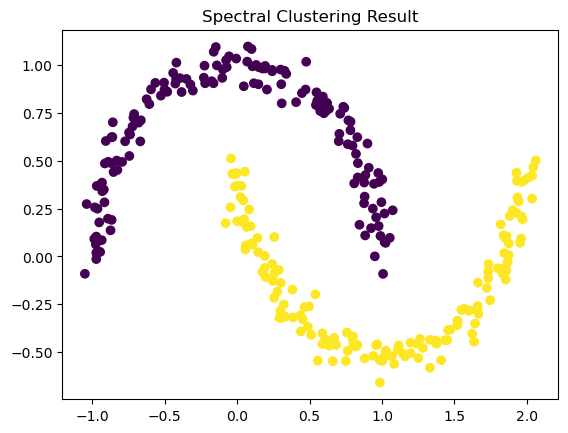

In [13]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

# 生成非线性可分数据
X, y_true = make_moons(n_samples=300, noise=0.05)

labels = spectral_clustering(X, n_clusters=2, sigma=0.15)

plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.title("Spectral Clustering Result")
plt.show()
